# Lecture 2: Introduction to Basic Forecasting Methods

**Goals of This Lecture:**

In the previous lecture, you learned how to generate, preprocess, and explore different types of time series data. Now, you will move a step further into forecasting using basic time series models. You will learn simple "benchmark" methods and then progress to more sophisticated ones.

By the end of this lecture, you should be able to:

- **Section 1:** Load a real-world time series (e.g., Tesla stock prices), visualize it, and apply a simple **Moving Average** forecast.
  You will learn how to:
  - Train/test split
  - In-sample (training) and out-of-sample (testing) forecasting
  - Visualize forecasts along with 90% confidence intervals

- **Section 2:** Introduce **Exponential Smoothing** methods (Simple, Holt, Holt-Winters).
  You will learn how to:
  - Apply these methods to the same dataset
  - Compare their pros and cons
  - Visualize their performance

- **Section 3:** Use an **Auto-ARIMA** model (an automated ARIMA model selection) for forecasting.
  You will learn:
  - The intuition behind ARIMA models
  - How Auto-ARIMA chooses model parameters
  - How to visualize and evaluate its forecasts

- **Section 4:** Implement a **Rolling Window Forecasting** approach for all methods.
  You will:
  - Fit the model on a moving window of data
  - Predict one-step ahead
  - Refit with new data and repeat
  - Visualize how this iterative forecasting process works

- **Section 5:** Compare the models using accuracy metrics (max_error, MAE, MSE, RMSE, MAPE, MASE) for both the simple out-of-sample forecasts and the rolling forecasts.

Throughout the code and markdown, you will see explanations in a second-person narrative, encouraging you to think actively about what you are doing. You need to pay attention to pros and cons of each method, understand their assumptions, and not just apply them blindly.


## SECTION 1: Data Loading, Visualization, and Moving Average Forecasting

In this section, you will:

1. Load a real-world time series dataset: Tesla stock prices.
2. Visualize the data to understand its characteristics.
3. Split the data into a training and testing period.
4. Introduce a Moving Average (MA) forecasting method:
   - Compute a simple moving average on the training set.
   - Forecast future values by using the MA model out-of-sample.
   - Visualize both in-sample and out-of-sample forecasts with confidence intervals.

**Why Moving Average?**
You may find the Moving Average (MA) a very basic approach: it simply averages the recent past values to predict the future. While simplistic, it serves as a good benchmark. It’s easy to understand and quick to implement.

**Pros:**
- Simple and quick to implement.
- Works reasonably well if the data is roughly stationary and lacks strong trends or seasonality.

**Cons:**
- Does not adapt well to trends or seasonal patterns.
- Equal weighting of past observations might not be realistic if more recent observations are more relevant.


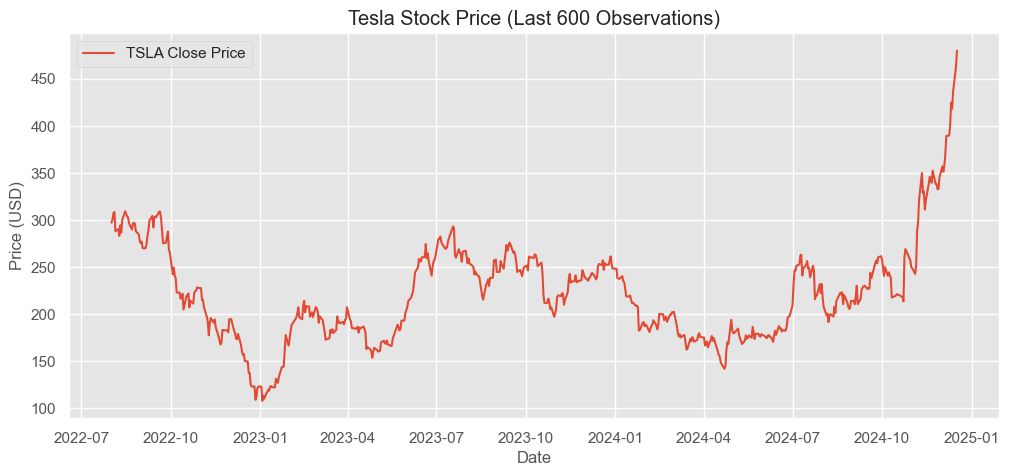

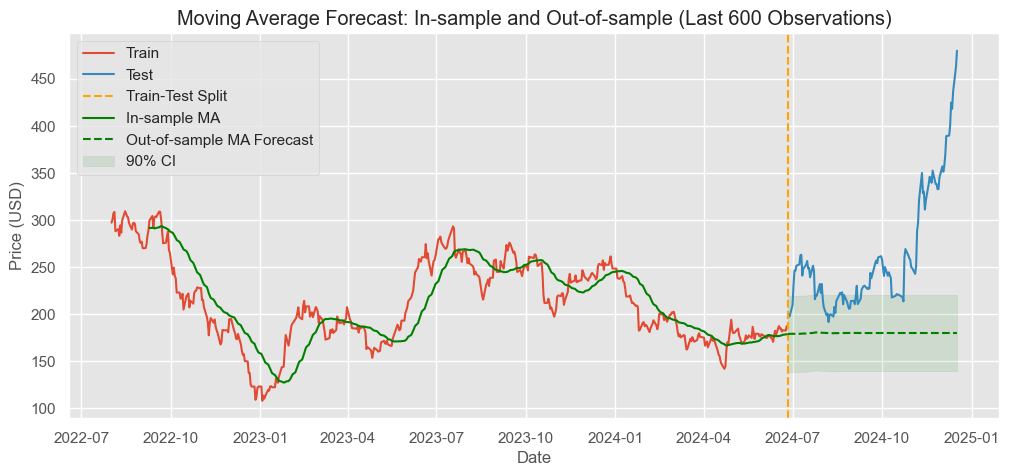

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.holtwinters import ExponentialSmoothing

sns.set()
plt.style.use('ggplot')

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

def mase(y_true, y_pred, y_train):
    # MASE = mean(|y_t - y_hat_t|)/mean(|y_t - y_t-1|)
    numerator = np.mean(np.abs(y_true - y_pred))
    denominator = np.mean(np.abs(np.diff(y_train)))
    return numerator/denominator

def bootstrap_confidence_intervals(predictions, residuals, alpha=0.1):
    if len(residuals) == 0:
        return predictions, predictions
    std_resid = np.std(residuals)
    z_value = 1.645  # ~90% CI
    lower = predictions - z_value * std_resid
    upper = predictions + z_value * std_resid
    return lower, upper

# Read the CSV file
# Make sure TSLA.csv is in the working directory
# Adjust the path if necessary
df = pd.read_csv('TSLA.csv', parse_dates=['date'], dayfirst=False)
# If the date format is month/day/year as shown, dayfirst should be False.

# Sort by date in ascending order to ensure chronological order
df = df.sort_values(by='date')

# Keep only the last 600 rows
df = df.tail(600)

# Set date as index
df.set_index('date', inplace=True)

# Work with the 'close' column as the time series
ts = df['close'].asfreq('B')  # Business frequency
ts = ts.fillna(method='ffill')  # forward fill if gaps appear

# Check if we have enough data
if len(ts) < 30:
    raise ValueError("Not enough data points after filtering to 600 rows.")

plt.figure(figsize=(12,5))
plt.plot(ts, label='TSLA Close Price')
plt.title("Tesla Stock Price (Last 600 Observations)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Train-test split
train_ratio = 0.8
split_index = int(len(ts)*train_ratio)
train_data = ts.iloc[:split_index]
test_data = ts.iloc[split_index:]

# Define a window size for moving average
window_size = 30
ma_train = train_data.rolling(window=window_size).mean()
ma_non_na = ma_train.dropna()

if ma_non_na.empty:
    raise ValueError("No non-NA values in the rolling mean. Consider a smaller window size.")

# Forecast with a moving average
ma_forecasts = []
historical_values = train_data.values.tolist()
for _ in test_data:
    if len(historical_values) < window_size:
        forecast_val = np.mean(historical_values)
    else:
        forecast_val = np.mean(historical_values[-window_size:])
    ma_forecasts.append(forecast_val)
    # Append the forecast as if it were observed for next step
    historical_values.append(forecast_val)

ma_forecasts = pd.Series(ma_forecasts, index=test_data.index)

# Compute residuals for CI
common_index = ma_non_na.index.intersection(train_data.index[window_size-1:])
residuals = train_data[common_index] - ma_non_na[common_index]
lower_ci, upper_ci = bootstrap_confidence_intervals(ma_forecasts, residuals)

# Plotting with green MA lines
plt.figure(figsize=(12,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.axvline(x=test_data.index[0], color='orange', linestyle='--', label='Train-Test Split')
plt.plot(ma_non_na, label='In-sample MA', color='green')
plt.plot(ma_forecasts, label='Out-of-sample MA Forecast', color='green', linestyle='--')
plt.fill_between(ma_forecasts.index, lower_ci, upper_ci, color='green', alpha=0.1, label='90% CI')

plt.title("Moving Average Forecast: In-sample and Out-of-sample (Last 600 Observations)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()



## SECTION 2: Exponential Smoothing Methods

Moving Average is a basic benchmark. Now, you move to **Exponential Smoothing**:

**Key Idea:**
- Unlike a simple MA that gives equal weight to recent observations, exponential smoothing applies exponentially decreasing weights as observations get older.
- Recent observations have more weight than older observations.

**Simple Exponential Smoothing (SES):**
- Good for data without a clear trend or seasonal pattern.

**Holt’s Method:**
- Extends SES by adding a trend component.

**Holt-Winters Method:**
- Extends Holt’s Method by adding a seasonal component.

**Pros:**
- Flexible and can model level, trend, and seasonality.
- Often performs well with many real-world series.

**Cons:**
- Requires careful selection of parameters (smoothing levels) or relying on automatic optimization.
- Not as sophisticated as ARIMA or other models for certain complex patterns.

You will:
1. Fit an Exponential Smoothing model (simple) on the training set.
2. Forecast out-of-sample.
3. Show confidence intervals.
4. Repeat with Holt and Holt-Winters for demonstration.


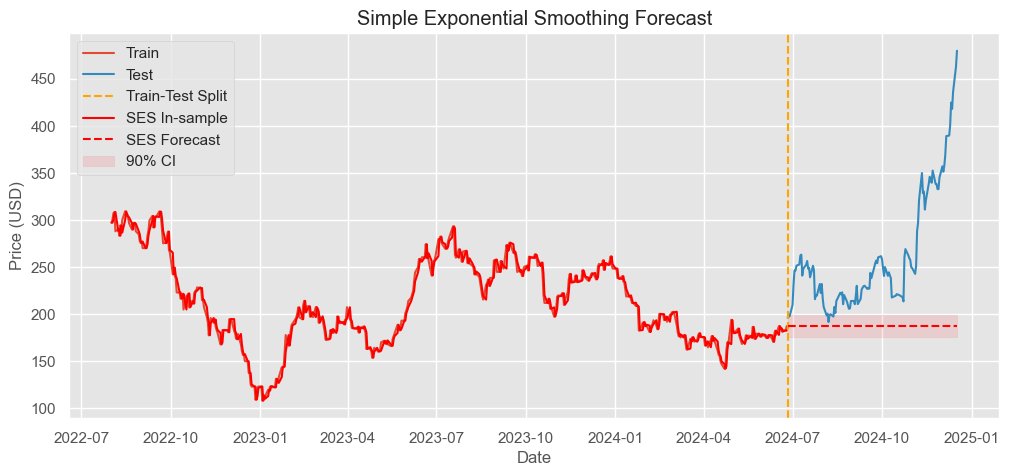

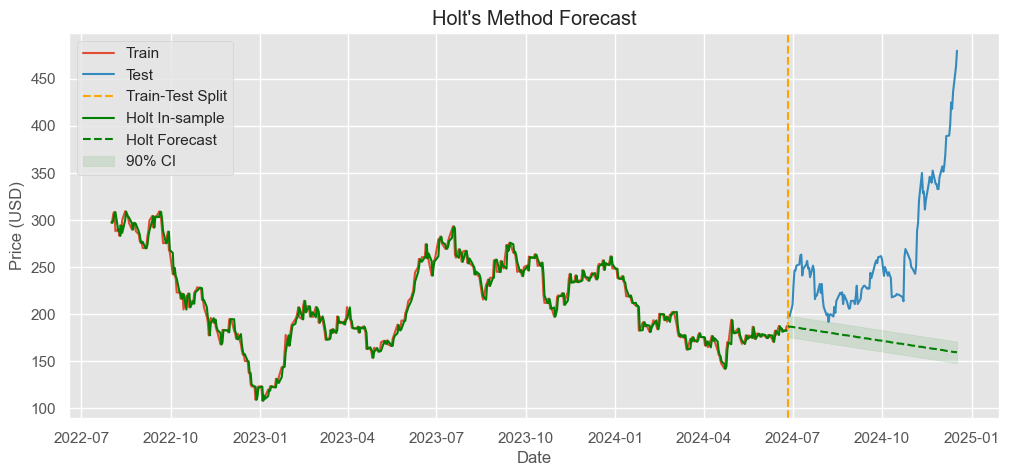

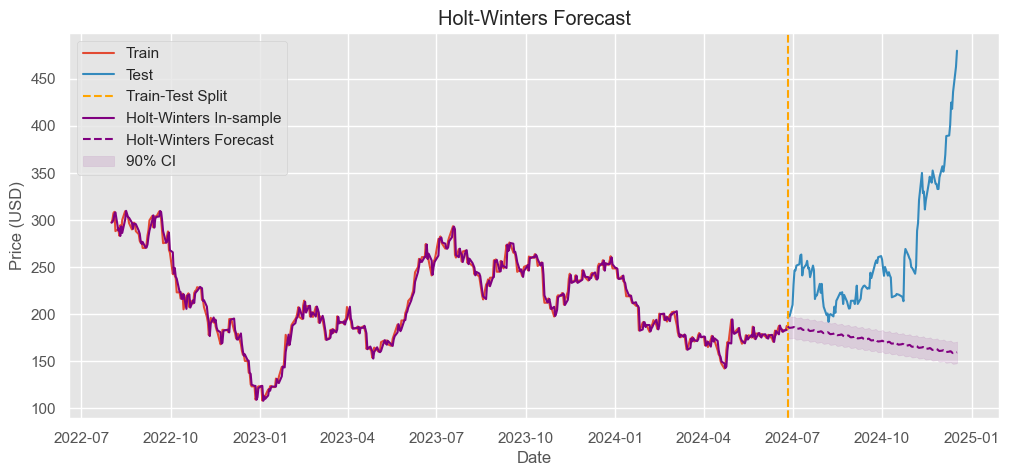

In [4]:
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses_model = SimpleExpSmoothing(train_data, initialization_method='estimated')
ses_fit = ses_model.fit()
ses_forecast = ses_fit.forecast(len(test_data))

# Holt’s Method (trend)
holt_model = ExponentialSmoothing(train_data, trend='add', initialization_method='estimated')
holt_fit = holt_model.fit()
holt_forecast = holt_fit.forecast(len(test_data))

# Holt-Winters (trend + seasonality)
hw_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=5, initialization_method='estimated')
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(len(test_data))

# SES Plot:
plt.figure(figsize=(12,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.axvline(x=test_data.index[0], color='orange', linestyle='--', label='Train-Test Split')
plt.plot(ses_fit.fittedvalues, label='SES In-sample', color='red')
plt.plot(ses_forecast, label='SES Forecast', color='red', linestyle='--')

ses_residuals = train_data - ses_fit.fittedvalues
ses_lower, ses_upper = bootstrap_confidence_intervals(ses_forecast, ses_residuals)
plt.fill_between(ses_forecast.index, ses_lower, ses_upper, color='red', alpha=0.1, label='90% CI')

plt.title("Simple Exponential Smoothing Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Holt Plot:
plt.figure(figsize=(12,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.axvline(x=test_data.index[0], color='orange', linestyle='--', label='Train-Test Split')
plt.plot(holt_fit.fittedvalues, label='Holt In-sample', color='green')
plt.plot(holt_forecast, label='Holt Forecast', color='green', linestyle='--')

holt_residuals = train_data - holt_fit.fittedvalues
holt_lower, holt_upper = bootstrap_confidence_intervals(holt_forecast, holt_residuals)
plt.fill_between(holt_forecast.index, holt_lower, holt_upper, color='green', alpha=0.1, label='90% CI')

plt.title("Holt's Method Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Holt-Winters:
plt.figure(figsize=(12,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.axvline(x=test_data.index[0], color='orange', linestyle='--', label='Train-Test Split')
plt.plot(hw_fit.fittedvalues, label='Holt-Winters In-sample', color='purple')
plt.plot(hw_forecast, label='Holt-Winters Forecast', color='purple', linestyle='--')

hw_residuals = train_data - hw_fit.fittedvalues
hw_lower, hw_upper = bootstrap_confidence_intervals(hw_forecast, hw_residuals)
plt.fill_between(hw_forecast.index, hw_lower, hw_upper, color='purple', alpha=0.1, label='90% CI')

plt.title("Holt-Winters Forecast")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


## SECTION 3: Auto-ARIMA

**Why ARIMA?**
- ARIMA models the data by using its own lags (AR) and past forecast errors (MA), and differencing (I) to achieve stationarity.
- It's more flexible and can model a range of patterns.

**Why AUTO-ARIMA?**
- Selecting ARIMA parameters (p, d, q) manually can be tedious.
- Auto-ARIMA uses criteria (like AIC) to automatically select the best parameters.

**Pros:**
- Systematically chosen parameters.
- Often yields better forecasts than simple methods.

**Cons:**
- More complex and computationally expensive.
- Assumes a certain form of linearity.

You will:
1. Fit an Auto-ARIMA model on the training data.
2. Forecast out-of-sample.
3. Show confidence intervals from the model.


Best ARIMA order: (0, 1, 2)  AIC: 3319.792822841512


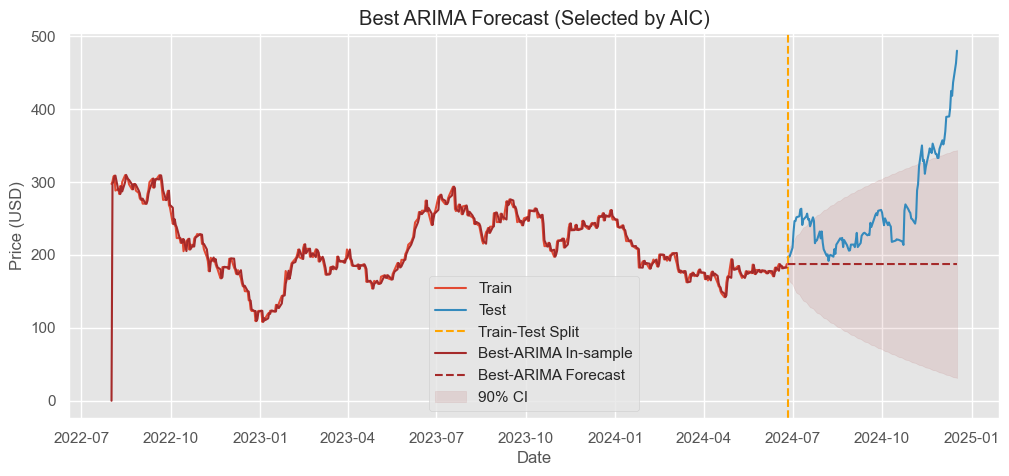

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set()
plt.style.use('ggplot')

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

def mase(y_true, y_pred, y_train):
    numerator = np.mean(np.abs(y_true - y_pred))
    denominator = np.mean(np.abs(np.diff(y_train)))
    return numerator/denominator

# Assume `train_data` and `test_data` are already defined as in previous code
# For demonstration, let's say we have them:
# Make sure you run this code after you have `train_data` and `test_data` defined from the previous steps.

# Parameter ranges for p, d, q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

best_aic = np.inf
best_order = None
best_model = None

for i in p:
    for j in d:
        for k in q:
            try:
                model = SARIMAX(train_data, order=(i,j,k), enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (i,j,k)
                    best_model = results
            except:
                continue

if best_model is None:
    raise ValueError("No suitable model found. Try expanding p,d,q ranges.")

print("Best ARIMA order:", best_order, " AIC:", best_aic)

# Forecast out-of-sample
n_periods = len(test_data)
forecast = best_model.get_forecast(steps=n_periods)
arima_pred = forecast.predicted_mean
arima_conf_int = forecast.conf_int()

# In-sample fitted values
arima_insample_fit = best_model.predict(start=train_data.index[0], end=train_data.index[-1])

plt.figure(figsize=(12,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.axvline(x=test_data.index[0], color='orange', linestyle='--', label='Train-Test Split')
plt.plot(arima_insample_fit, label='Best-ARIMA In-sample', color='brown')
plt.plot(arima_pred, label='Best-ARIMA Forecast', color='brown', linestyle='--')
plt.fill_between(arima_pred.index, arima_conf_int.iloc[:,0], arima_conf_int.iloc[:,1], color='brown', alpha=0.1, label='90% CI')

plt.title("Best ARIMA Forecast (Selected by AIC)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


## SECTION 4: Rolling Window Forecasting

So far, you’ve fitted each model once and forecasted the entire test set. In reality, you often update your model as new data comes in, producing forecasts one step at a time. This is called rolling or iterative forecasting.

**Process:**
1. Start with an initial training window.
2. Fit the model on this window.
3. Forecast one step ahead.
4. Add the observed value to your training data (roll the window forward) and refit.
5. Repeat until you’ve forecasted the entire test period step-by-step.

**Pros:**
- More realistic scenario.

**Cons:**
- More computationally expensive.

You will implement rolling forecasts for:
- Moving Average (MA)
- Holt-Winters (as a representative exponential smoothing)
- Auto-ARIMA


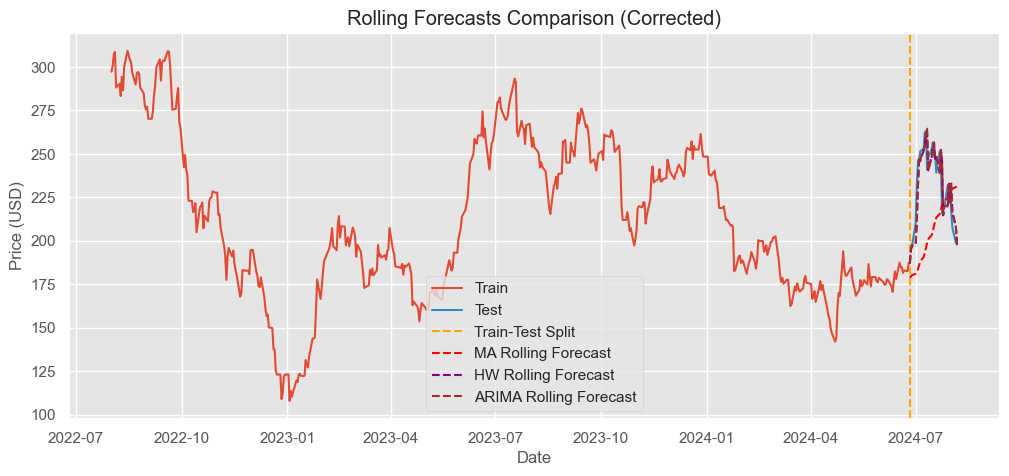

In [13]:
def rolling_forecast(train, test, fit_func, pred_func):
    history = train.copy()
    forecasts = []
    for t in test:
        fitted_model = fit_func(history)
        fcast = pred_func(fitted_model, steps=1)
        # Ensure fcast is a single float, not a list or array
        if isinstance(fcast, (list, np.ndarray)):
            fcast = fcast[0]  # extract the first element
        forecasts.append(fcast)
        history = pd.concat([history, pd.Series([t], index=[test.index[len(forecasts)-1]])])
    return pd.Series(forecasts, index=test.index)

# Rolling for MA:
def ma_fit_func(hist):
    return hist

def ma_pred_func(hist, steps=1):
    # Return a float instead of a list
    if len(hist) >= window_size:
        return np.mean(hist.iloc[-window_size:])
    else:
        return np.mean(hist)

ma_rolling_forecast = rolling_forecast(train_data, test_data, ma_fit_func, ma_pred_func)

# Rolling for Holt-Winters:
def hw_fit_func(hist):
    model = ExponentialSmoothing(hist, trend='add', seasonal='add', seasonal_periods=5, initialization_method='estimated')
    return model.fit()

def hw_pred_func(fitted_model, steps=1):
    # forecast returns a pandas Series, so take the first value (a float)
    return fitted_model.forecast(steps=steps).iloc[0]

hw_rolling_forecast = rolling_forecast(train_data, test_data, hw_fit_func, hw_pred_func)

# Rolling for ARIMA (using the best_order approach):
def arima_fit_func(hist):
    model = SARIMAX(hist, order=best_order, enforce_stationarity=False, enforce_invertibility=False)
    return model.fit(disp=False)

def arima_pred_func(model, steps=1):
    # forecast returns a Series, take the first element as float
    return model.forecast(steps=steps).iloc[0]

arima_rolling_forecast = rolling_forecast(train_data, test_data, arima_fit_func, arima_pred_func)

# Visualization
plt.figure(figsize=(12,5))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.axvline(x=test_data.index[0], color='orange', linestyle='--', label='Train-Test Split')
plt.plot(ma_rolling_forecast, label='MA Rolling Forecast', linestyle='--', color='red')
plt.plot(hw_rolling_forecast, label='HW Rolling Forecast', linestyle='--', color='purple')
plt.plot(arima_rolling_forecast, label='ARIMA Rolling Forecast', linestyle='--', color='brown')

plt.title("Rolling Forecasts Comparison (Corrected)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


## SECTION 5: Accuracy Comparison

Now that you have forecasts from multiple models in both the simple out-of-sample scenario and the rolling scenario, you should compare their accuracy.

**Metrics:**
- max_error
- MAE (Mean Absolute Error)
- MSE (Mean Squared Error)
- RMSE (Root MSE)
- MAPE (Mean Absolute Percentage Error)
- MASE (Mean Absolute Scaled Error)

You will:
1. Compute these metrics for the simple out-of-sample forecasts.
2. Compute these metrics for the rolling forecasts.
3. Present them in a table for easy comparison.


In [15]:
def compute_metrics(y_true, y_pred, y_train):
    """
    Compute various forecast accuracy metrics comparing y_true and y_pred.
    Both y_true and y_pred should be the same length and aligned on the same index.
    y_train is used to compute MASE and should represent the historical training data.
    """
    return {
        'max_error': max_error(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAPE': mape(y_true, y_pred),
        'MASE': mase(y_true, y_pred, y_train)
    }

# Ensure all forecast series are aligned and trimmed to the length of test_data
ma_forecasts = ma_forecasts.loc[test_data.index]
ses_forecast = ses_forecast.loc[test_data.index]
holt_forecast = holt_forecast.loc[test_data.index]
hw_forecast = hw_forecast.loc[test_data.index]
arima_pred = arima_pred.loc[test_data.index]

ma_rolling_forecast = ma_rolling_forecast.loc[test_data.index]
hw_rolling_forecast = hw_rolling_forecast.loc[test_data.index]
arima_rolling_forecast = arima_rolling_forecast.loc[test_data.index]

# Compute metrics for simple (non-rolling) out-of-sample forecasts
simple_results = pd.DataFrame({
    'MA': compute_metrics(test_data, ma_forecasts, train_data),
    'SES': compute_metrics(test_data, ses_forecast, train_data),
    'Holt': compute_metrics(test_data, holt_forecast, train_data),
    'Holt-Winters': compute_metrics(test_data, hw_forecast, train_data),
    'Auto-ARIMA': compute_metrics(test_data, arima_pred, train_data)
}).T

print("Simple Out-of-Sample Forecasting Accuracy:")
print(simple_results)

# Compute metrics for rolling forecasts
rolling_results = pd.DataFrame({
    'MA': compute_metrics(test_data, ma_rolling_forecast, train_data),
    'Holt-Winters': compute_metrics(test_data, hw_rolling_forecast, train_data),
    'Auto-ARIMA': compute_metrics(test_data, arima_rolling_forecast, train_data)
}).T

print("\nRolling Forecasting Accuracy:")
print(rolling_results)


Simple Out-of-Sample Forecasting Accuracy:
              max_error        MAE          MSE       RMSE       MAPE  \
MA            83.930635  52.092025  3163.088812  56.241344  21.792251   
SES           75.940536  44.539869  2429.321793  49.288151  18.509275   
Holt          78.399035  48.002095  2741.100119  52.355517  20.025110   
Holt-Winters  78.568436  48.662526  2801.779042  52.931834  20.315475   
Auto-ARIMA    75.810577  44.414622  2417.846678  49.171604  18.455137   

                   MASE  
MA            10.197554  
SES            8.719141  
Holt           9.396908  
Holt-Winters   9.526194  
Auto-ARIMA     8.694623  

Rolling Forecasting Accuracy:
              max_error        MAE          MSE       RMSE       MAPE  \
MA            69.156333  33.193233  1549.624975  39.365276  13.870619   
Holt-Winters  30.187671   8.406883   117.653851  10.846836   3.674936   
Auto-ARIMA    29.032682   8.470601   120.950834  10.997765   3.700454   

                  MASE  
MA           

# Summary & Conclusion

In this lecture, you:

- Learned how to load and visualize real-world stock price data.
- Applied a simple Moving Average forecast and discussed its limitations.
- Explored Exponential Smoothing (SES, Holt, Holt-Winters) and saw how adding trend/seasonality can improve forecasts.
- Used Auto-ARIMA to automatically select model parameters and generate forecasts.
- Implemented a Rolling Window Forecasting approach for a more realistic scenario of continuously updating models.
- Compared all models using multiple accuracy metrics.

**Key Takeaways:**
- Always start with simple models as benchmarks.
- Exponential smoothing methods can handle trend and seasonality relatively easily.
- ARIMA-based models are more flexible but more complex.
- Rolling forecasts present a more realistic scenario.

In future lectures, you may dive deeper into advanced models and more nuanced techniques.

Keep exploring and challenging your assumptions as you gain more experience with forecasting.
